In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

2024-09-24 17:03:18.867412: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-09-24 17:03:20.443013: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:d8:00.0
2024-09-24 17:03:20.443283: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-09-24 17:03:20.444832: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-09-24 17:03:20.446082: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-09-24 17:03:20.446412: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2024-09-24 17:03:20.447878: I tensorflow/stream_executor

In [3]:
mean_1 = [0, 0]
cov_1 = [[0.25, 0], [0, 0.25]]

mean_2 = [1, 1]
cov_2 = [[0.25, 0], [0, 0.25]]

x_1 = np.random.multivariate_normal(mean_1, cov_1, size=1000000)
y_1 = np.random.multivariate_normal(mean_1, cov_1, size=1000000)
x_2 = np.random.multivariate_normal(mean_2, cov_2, size=1000000)
y_2 = np.random.multivariate_normal(mean_2, cov_2, size=1000000)

In [4]:
print(x_1[0])

[ 1.02857139 -0.73065816]


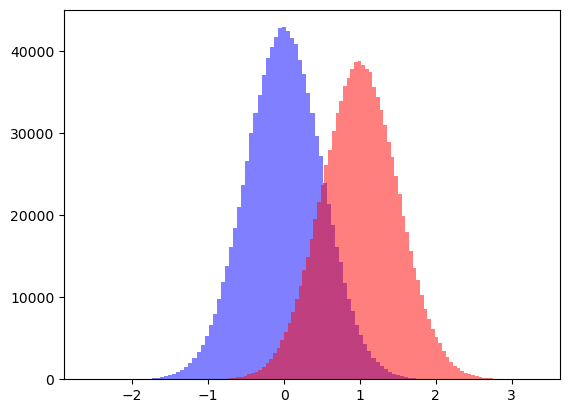

In [5]:
plt.hist(y_1[:,1], alpha = 0.5, bins = 100, color = 'b')
plt.hist(y_2[:,1], alpha = 0.5, bins = 100, color = 'r')
plt.show()

In [6]:
x_sig_1 = x_1[0:250000]
true_label_sig_1 = np.zeros_like(x_sig_1[:,0])
x_sig_2 = x_2[0:10000]
true_label_sig_2 = np.ones_like(x_sig_2[:,0])
x_bkg_1 = x_1[250000:509500]
true_label_bkg_1 = np.ones_like(x_bkg_1[:,0])
x_bkg_2 = x_2[0:500]
true_label_bkg_2 = np.zeros_like(x_bkg_2[:,0])

In [7]:
rng = np.random.default_rng()
x_sig = np.concatenate((x_sig_1, x_sig_2))
x_bkg = np.concatenate((x_bkg_1, x_bkg_2))
true_label_sig = np.concatenate((true_label_sig_1, true_label_sig_2))
true_label_bkg = np.concatenate((true_label_bkg_1, true_label_bkg_2))

indices_sig = rng.permutation(np.shape(x_sig)[0])
indices_bkg = rng.permutation(np.shape(x_bkg)[0])


x_sig = x_sig[indices_sig]
true_label_sig = true_label_sig[indices_sig]

x_bkg = x_bkg[indices_bkg]
true_label_bkg = true_label_bkg[indices_bkg]

In [8]:
print(true_label_sig)

[0. 0. 0. ... 0. 0. 0.]


In [9]:
print(np.shape(x_sig))

(260000, 2)


In [10]:
print(np.shape(x_sig[true_label_sig == 0.]))

(250000, 2)


In [11]:
print(np.shape(x_sig), np.shape(x_bkg))

(260000, 2) (260000, 2)


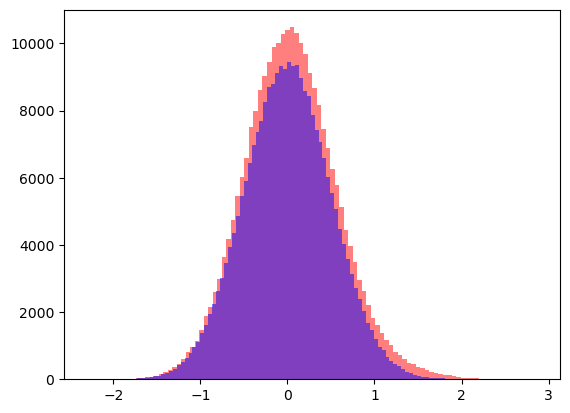

In [12]:
plt.hist(x_sig[:,0], alpha = 0.5, bins = 100, color = 'r')
plt.hist(x_bkg[:,1], alpha = 0.5, bins = 100, color = 'b')
plt.show()

Without bootstrapping

In [13]:
def CWoLA():
    input_1 = keras.layers.Input(shape = (2))
    dnn = keras.Sequential([
          keras.layers.Dense(16, activation = 'relu'),
          keras.layers.Dense(16, activation = 'relu'),
          keras.layers.Dense(1, activation = 'sigmoid')
    ])
    x = dnn(input_1)
    return keras.Model(         
    inputs=[input_1],
    outputs=x,)

In [14]:
y_sig = np.ones(np.shape(x_sig)[0])
y_bkg = np.zeros(np.shape(x_bkg)[0])

y_train = np.concatenate((y_sig, y_bkg))
x_train = np.concatenate((x_sig, x_bkg))
true_label_train = np.concatenate((true_label_sig, true_label_bkg))

indices_train = rng.permutation(np.shape(x_sig)[0])

x_train = x_train[indices_train]
y_train = y_train[indices_train]
true_label_train = true_label_train[indices_train]

cwola = CWoLA()
loss_object = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
cwola.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=30, restore_best_weights=True)
cwola.fit(x_train, y_train, validation_split = 0.2,
        shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 10)  

2024-09-24 17:03:47.283928: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2024-09-24 17:03:47.320825: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3200000000 Hz
2024-09-24 17:03:47.323538: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5650693ed8d0 executing computations on platform Host. Devices:
2024-09-24 17:03:47.323590: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2024-09-24 17:03:47.326283: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:d8:00.0
2024-09-24 17:03:47.326413: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-09-24 17:03:47.326445: I tenso

Train on 208000 samples, validate on 52000 samples
Epoch 1/10
  9000/208000 [>.............................] - ETA: 17s - loss: 0.7314 - accuracy: 0.2587 

2024-09-24 17:03:48.435512: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


208000/208000 [==============================] - 2s 11us/sample - loss: 0.6178 - accuracy: 0.8328 - val_loss: 0.4946 - val_accuracy: 1.0000
Epoch 2/10
208000/208000 [==============================] - 2s 8us/sample - loss: 0.3768 - accuracy: 1.0000 - val_loss: 0.2718 - val_accuracy: 1.0000
Epoch 3/10
208000/208000 [==============================] - 2s 8us/sample - loss: 0.1944 - accuracy: 1.0000 - val_loss: 0.1322 - val_accuracy: 1.0000
Epoch 4/10
208000/208000 [==============================] - 2s 8us/sample - loss: 0.0935 - accuracy: 1.0000 - val_loss: 0.0643 - val_accuracy: 1.0000
Epoch 5/10
208000/208000 [==============================] - 2s 8us/sample - loss: 0.0468 - accuracy: 1.0000 - val_loss: 0.0336 - val_accuracy: 1.0000
Epoch 6/10
208000/208000 [==============================] - 2s 8us/sample - loss: 0.0253 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy: 1.0000
Epoch 7/10
208000/208000 [==============================] - 2s 8us/sample - loss: 0.0147 - accuracy: 1.0000 - 

In [20]:
x_test = np.concatenate((y_1, y_2))

y_test_sig = np.ones(np.shape(y_2)[0])
y_test_bkg = np.zeros(np.shape(y_1)[0])
y_test = np.concatenate((y_test_bkg, y_test_sig))

In [21]:
x_predict = cwola.predict(x_test)

In [22]:
x_predict_0 = x_predict[y_test == 0]
x_predict_1 = x_predict[y_test == 1]


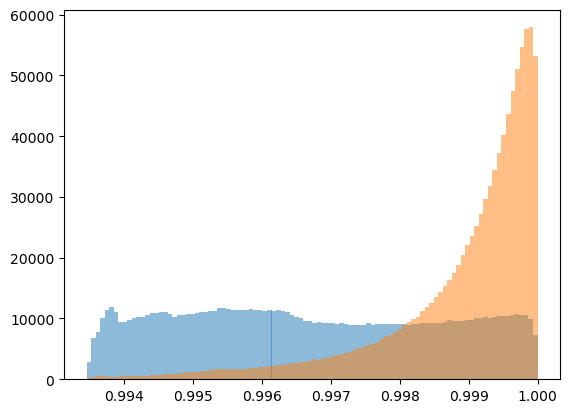

In [23]:
plt.hist(x_predict_0, bins = 100, alpha = 0.5)
plt.hist(x_predict_1, bins = 100, alpha = 0.5)
plt.show()

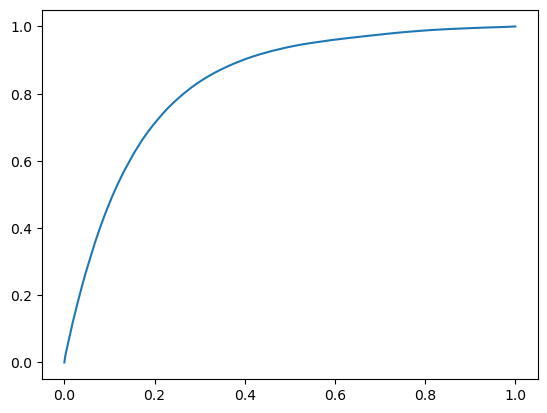

0.8339552112519999


In [25]:
fpr, tpr, th = roc_curve(y_test, x_predict)
plt.plot(fpr, tpr)
plt.show()
f = interpolate.interp1d(fpr, tpr)
epsilon_s = f([0.001, 0.01, 0.1])
print(roc_auc_score(y_test, x_predict))

With bootstrapping

In [26]:
y_sig = np.ones(np.shape(x_sig)[0])
y_bkg = np.zeros(np.shape(x_bkg)[0])

y_train = np.concatenate((y_sig, y_bkg))
x_train = np.concatenate((x_sig, x_bkg))
true_label_train = np.concatenate((true_label_sig, true_label_bkg))

indices_train = rng.permutation(np.shape(x_sig)[0])

x_train = x_train[indices_train]
y_train = y_train[indices_train]
true_label_train = true_label_train[indices_train]

cwola_2 = CWoLA()
loss_object = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
cwola_2.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=30, restore_best_weights=True)
for i in range(5):
    cwola_2.fit(x_train, y_train, validation_split = 0.2,
            shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 2)  
    
    predict = (cwola_2.predict(x_train)).flatten()
    
    predict_array = np.zeros_like(y_train)
    predict_array[predict >= np.median(predict)] = 1
    y_train = predict_array
    print(y_train)
    

Train on 208000 samples, validate on 52000 samples
Epoch 1/2
208000/208000 [==============================] - 2s 10us/sample - loss: 0.5844 - accuracy: 0.9480 - val_loss: 0.4653 - val_accuracy: 1.0000
Epoch 2/2
208000/208000 [==============================] - 2s 8us/sample - loss: 0.3398 - accuracy: 1.0000 - val_loss: 0.2317 - val_accuracy: 1.0000
[0. 1. 0. ... 0. 1. 0.]
Train on 208000 samples, validate on 52000 samples
Epoch 1/2
208000/208000 [==============================] - 2s 8us/sample - loss: 0.6624 - accuracy: 0.4998 - val_loss: 0.5955 - val_accuracy: 0.5006
Epoch 2/2
208000/208000 [==============================] - 2s 8us/sample - loss: 0.5408 - accuracy: 0.5803 - val_loss: 0.4902 - val_accuracy: 0.7554
[1. 1. 0. ... 0. 1. 0.]
Train on 208000 samples, validate on 52000 samples
Epoch 1/2
208000/208000 [==============================] - 2s 8us/sample - loss: 0.4093 - accuracy: 0.8641 - val_loss: 0.3548 - val_accuracy: 0.9174
Epoch 2/2
208000/208000 [============================

In [27]:
x_predict = cwola_2.predict(x_test)

In [28]:
x_predict_0 = x_predict[y_test == 0]
x_predict_1 = x_predict[y_test == 1]

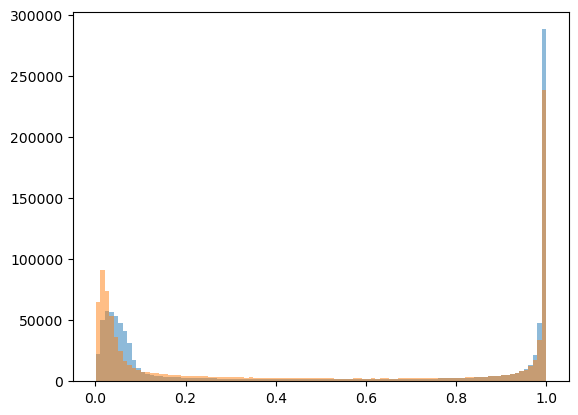

In [29]:
plt.hist(x_predict_0, bins = 100, alpha = 0.5)
plt.hist(x_predict_1, bins = 100, alpha = 0.5)
plt.show()

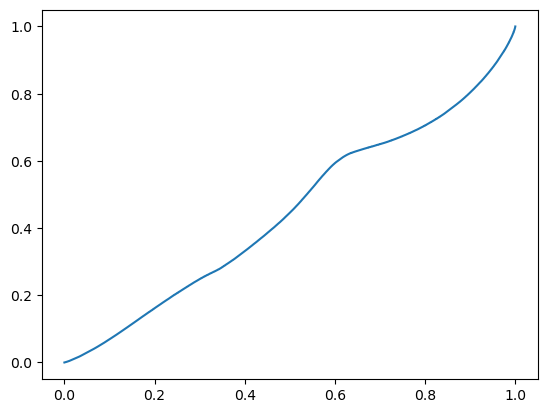

0.4481149755450001


In [30]:
fpr, tpr, th = roc_curve(y_test, x_predict)
plt.plot(fpr, tpr)
plt.show()
f = interpolate.interp1d(fpr, tpr)
epsilon_s = f([0.001, 0.01, 0.1])
print(roc_auc_score(y_test, x_predict))